In [1]:
# library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm

%matplotlib inline

In [2]:
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')
df.head(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers


## Part 1: Analyzing Best-Seller Trends Across Product Categories

### 1. Crosstab Analysis:

Create a crosstab between the product category and the is BestSeller status.

In [3]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'])
crosstab.head()

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3


Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [4]:
prop_best_seller = crosstab[True] / crosstab.sum(axis=1)*100
prop_best_seller_sorted = prop_best_seller.sort_values(ascending=False)
prop_best_seller_sorted

category
Grocery                             5.813467
Smart Home Security & Lighting      5.769231
Health & Personal Care              5.768628
Mobile Phone Accessories            4.247104
Power & Hand Tools                  3.533895
                                      ...   
CD, Disc & Tape Players             0.000000
General Music-Making Accessories    0.000000
Snowboard Boots                     0.000000
Boxes & Organisers                  0.000000
eBook Readers & Accessories         0.000000
Length: 296, dtype: float64

### 2. Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

In [5]:
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab)
chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

Compute Cramér's V to understand the strength of association between best-seller status and category.

In [6]:
association(crosstab.values, method="cramer")

0.1222829439760564

In [7]:
# Cramer's V value of 0.122 indicates a weak association between the two variables.

### 3.Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [9]:
crosstab.sort_values(by=True,ascending=False)

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


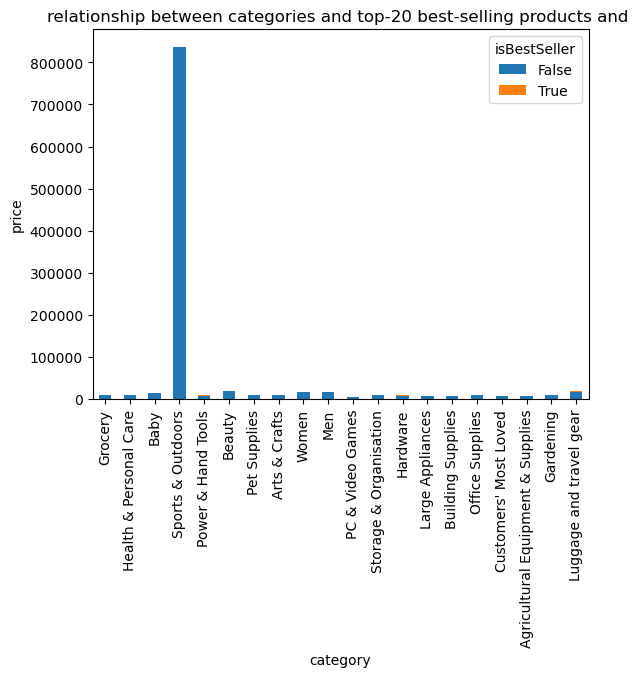

In [10]:
top_20_best_seller = crosstab.sort_values(by=True,ascending=False).head(20)
top_20_best_seller.plot(kind="bar", stacked=True)
plt.xlabel('category')
plt.ylabel('price')
plt.title('relationship between categories and top-20 best-selling products and ')
plt.show()

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

### 0. Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [14]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers



In [18]:
outliers = tukeys_test_outliers(df['price'])
df_no_outliers = df[~df['price'].isin(outliers)]

print(f"Original dataset rows: {df.shape[0]}")
print(f"Dataset rows after removing the outliers: {df_no_outliers.shape[0]}")

Original dataset rows: 2443651
Dataset rows after removing the outliers: 2115963


### 1. Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.

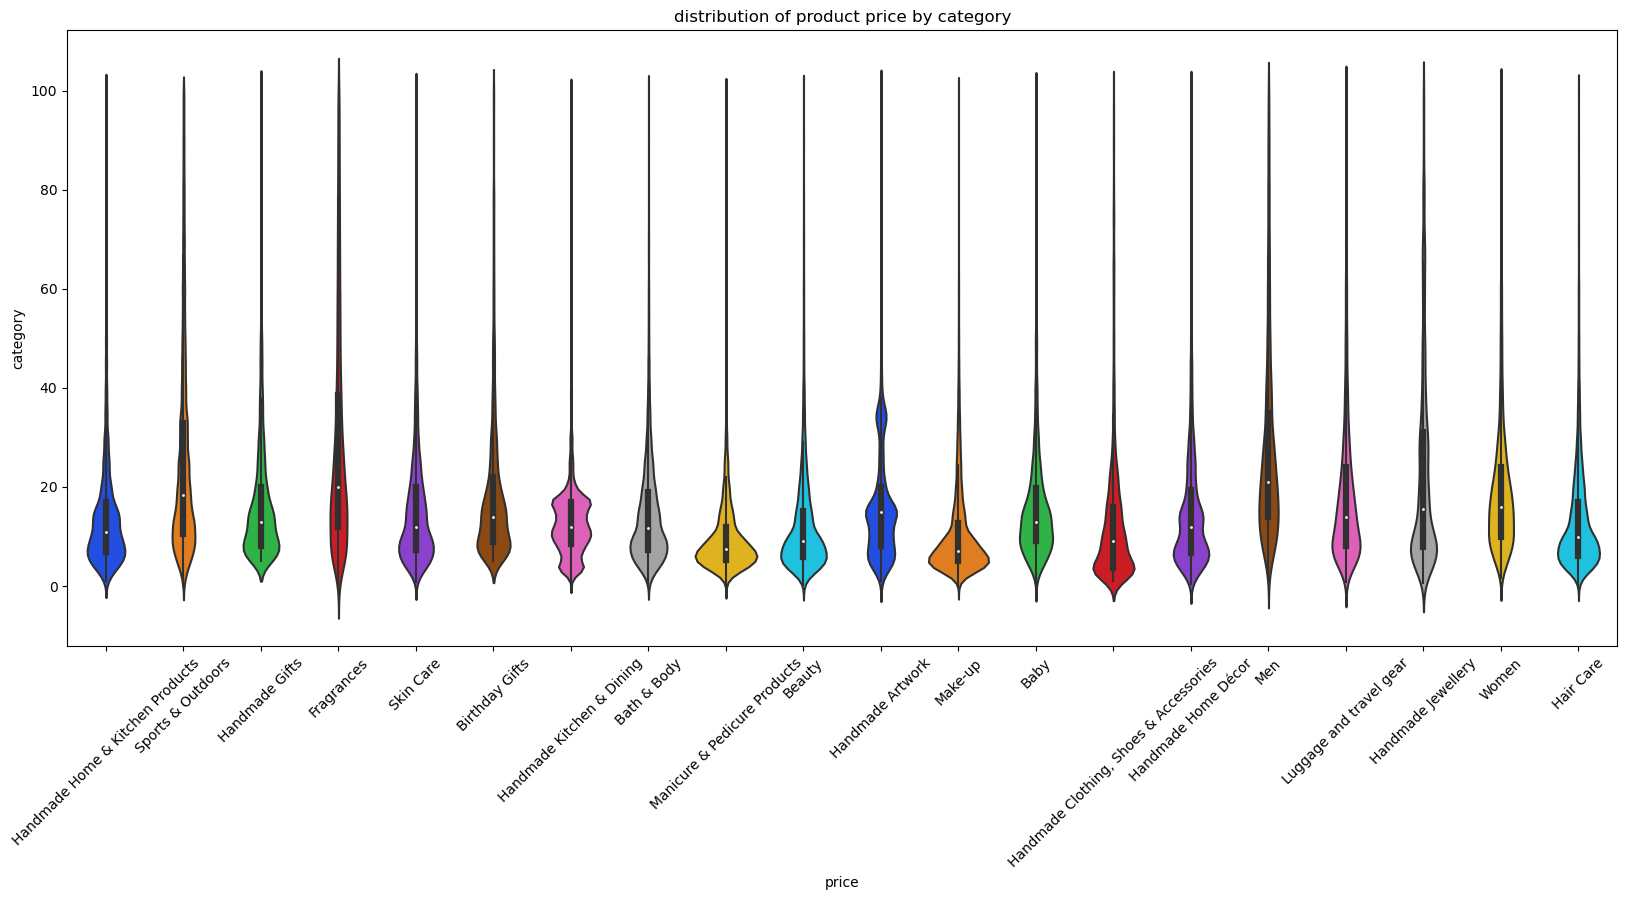

In [28]:
top_20_categories = df_no_outliers['category'].value_counts().head(20).index
df_top_20_categories = df_no_outliers[df_no_outliers['category'].isin(top_20_categories)]

plt.figure(figsize=(20,8))
sns.violinplot(data=df_top_20_categories, x='category', y='price', palette="bright")

plt.xlabel('price')
plt.ylabel('category')
plt.title('distribution of product price by category')
plt.xticks(rotation=45)
plt.show()

Which product category tends to have the highest median price? Don't filter here by top categories.

In [60]:
med_price_per_cat = df_no_outliers.groupby('category')['price'].median()

highest_med_price = med_price_per_cat.max()
highest_med_price_cat = med_price_per_cat.idxmax()

print(f"Category with the Highest Median Price({highest_med_price}): {highest_med_price_cat}")

Category with the Highest Median Price(74.0): Desktop PCs


### 2. Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

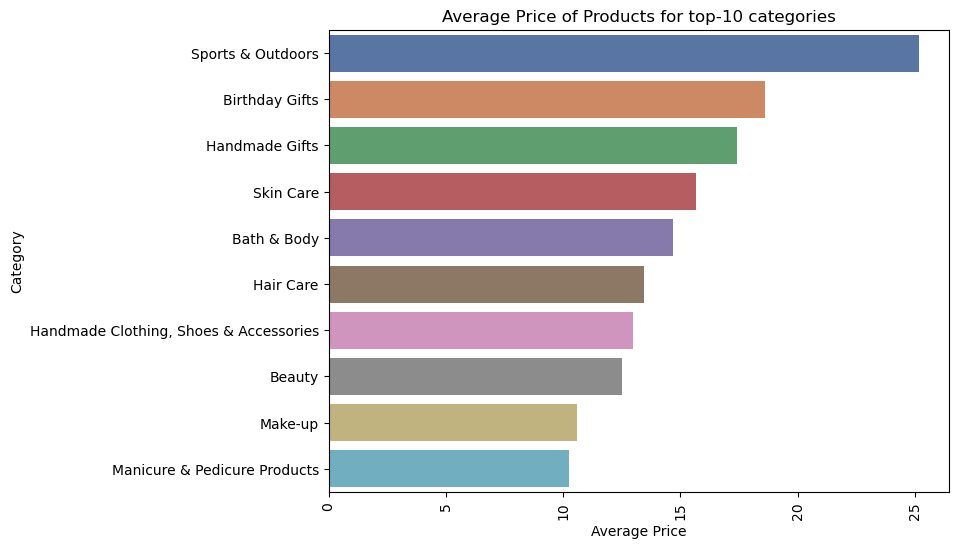

In [72]:
top_10_categories = df_no_outliers['category'].value_counts().head(10).index

df_top_10_categories = df_no_outliers[df_no_outliers['category'].isin(top_10_categories)]

ave_price = df_top_10_categories.groupby('category')['price'].mean().reset_index()
ave_price_sorted = ave_price.sort_values(by='price', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=average_prices_sorted,x='price', y='category',palette="deep", order=average_prices_sorted['category'])

plt.xlabel('Average Price')
plt.ylabel('Category')
plt.title('Average Price of Products for top-10 categories')
plt.xticks(rotation=90)
plt.show()

Which product category commands the highest average price? Don't filter here by top categories.

In [61]:
ave_price_cat = df_no_outliers.groupby('category')['price'].mean()

highest_ave_price = round(ave_price_cat.max(),2)
highest_ave_price_cat = ave_price_cat.idxmax()

print(f"Category with the Highest Average Price ({highest_ave_price}): {highest_ave_price_cat}")

Category with the Highest Average Price (68.77): Motherboards


### 3. Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

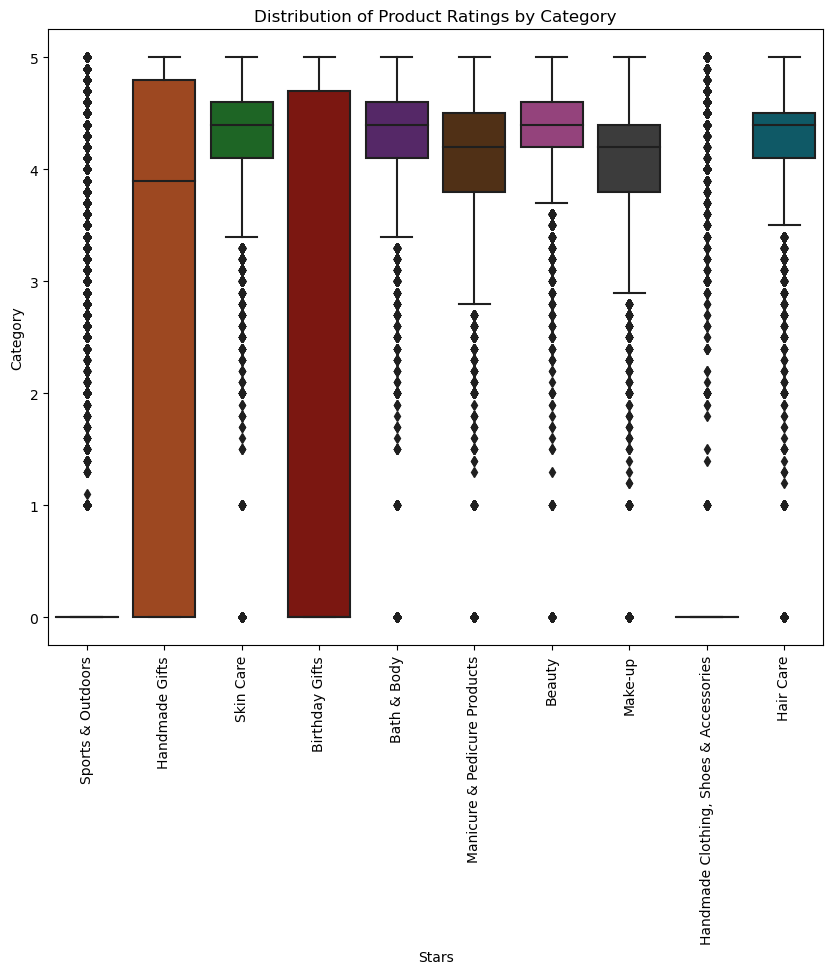

In [70]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_top_10_categories, x='category', y='stars', palette="dark")

plt.xlabel('Stars')
plt.ylabel('Category')
plt.title('Distribution of Product Ratings by Category')
plt.xticks(rotation=90)
plt.show()

Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [75]:
med_rate_cat = df_no_outliers.groupby('category')['stars'].median()

highest_med_rate = med_rate_cat.max()
highest_med_rate_cat = med_rate_cat.idxmax()

print(f"Category with the Highest Median Rating ({highest_med_rate}):{highest_med_rate_cat}")

Category with the Highest Median Rating (4.7):Computer Memory


## Part 3: Investigating the Interplay Between Product Prices and Ratings

### 1.Correlation Coefficients:

Calculate the correlation coefficient between price and stars.

In [81]:
corr_pearson = df_no_outliers['price'].corr(df_no_outliers['stars'])
corr_spearman = df_no_outliers['price'].corr(df_no_outliers['stars'], method='spearman')

print("Correlation Coefficient between Price and Stars:")
print(f"Pearson: {corr_pearson}")
print(f"Spearman: {corr_spearman}")

Correlation Coefficient between Price and Stars:
Pearson: -0.07767299878181352
Spearman: -0.06679697280768393


Is there a significant correlation between product price and its rating?

In [ ]:
# the correlation is very low and is negative which indicates that expensive products have lower ratings.

### 3.Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

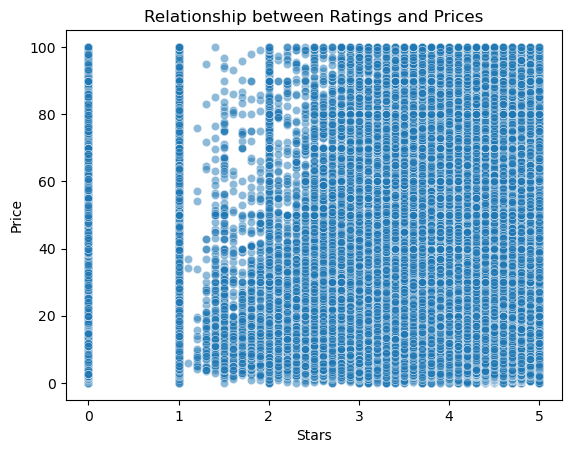

In [84]:
sns.scatterplot(data=df_no_outliers, x='stars', y='price')

plt.xlabel('Stars')
plt.ylabel('Price')
plt.title('Relationship between Ratings and Prices')
plt.show()

Use a correlation heatmap to visualize correlations between all numerical variables.

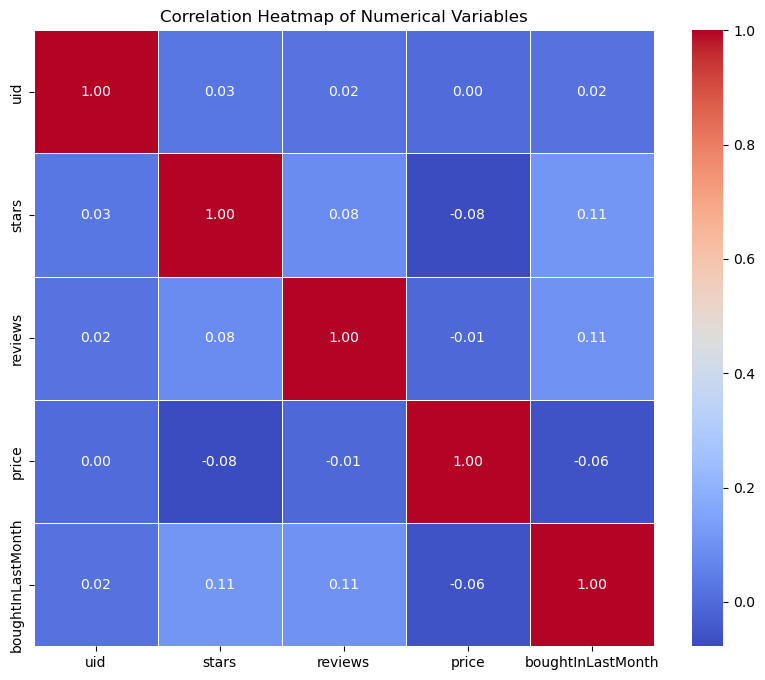

In [88]:
num = df_no_outliers.select_dtypes(include=['number'])
corr_matrix = num.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

Examine if product prices typically follow a normal distribution using a QQ plot.

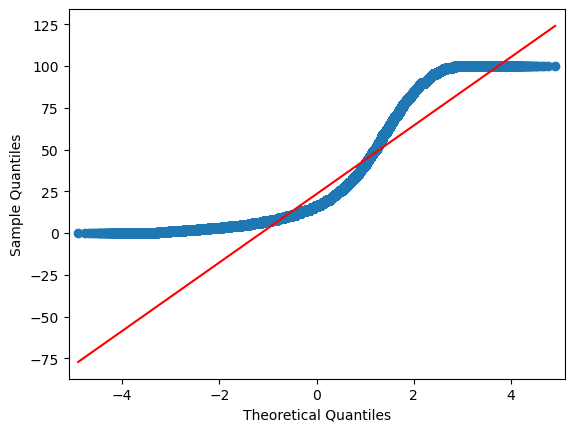

In [89]:
sm.qqplot(df_no_outliers['price'], line='s');

/var/folders/0p/4pk339j10111qhkt__jby28r0000gn/T/ipykernel_7010/298662420.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_no_outliers['price'])


<Axes: xlabel='price', ylabel='Density'>

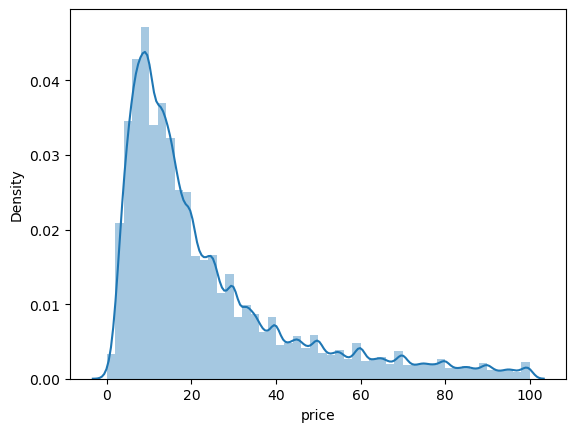

In [90]:
sns.distplot(df_no_outliers['price'])